In [1]:
import numpy as np
import matplotlib.pyplot as plt
import cvxpy as cp
from rsome import ro
from rsome import grb_solver as grb
import rsome as rso
import numpy as np

import torch
from torch import nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

import pandas as pd
import sbibm

In [2]:
plt.rcParams['mathtext.fontset'] = 'stix'
plt.rcParams['font.family'] = 'STIXGeneral'

SMALL_SIZE = 12
MEDIUM_SIZE = 14
BIGGER_SIZE = 18

plt.rc('font', size=BIGGER_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=BIGGER_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=BIGGER_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=BIGGER_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=BIGGER_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=BIGGER_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

In [3]:
task_name = "two_moons"

task = sbibm.get_task(task_name)
prior = task.get_prior_dist()
simulator = task.get_simulator()

# used for setting up dimensions
sample_c = prior.sample((1,))
sample_x = simulator(sample_c)
n = sample_c.shape[-1] # number of items (c in R^n)
d = sample_x.shape[-1] # dim of context to utility (x in R^d)

In [4]:
theta = np.random.randint(low=0, high=2, size=(d, n)) # theta has to be globally fixed to ensure exchangeability

def g(x):
    c = (x @ theta) ** 2
    return c

In [5]:
N = 2_000
N_train = 1000
N_test  = 1000

c_dataset = prior.sample((N,)).numpy()
x_dataset = simulator(c_dataset).numpy()

device = ("cuda" if torch.cuda.is_available() else "cpu")
to_tensor = lambda r : torch.tensor(r).to(torch.float32).to(device)
x_train, x_cal = to_tensor(x_dataset[:N_train]), to_tensor(x_dataset[N_train:])
c_train, c_cal = to_tensor(c_dataset[:N_train]), to_tensor(c_dataset[N_train:])

c_test = prior.sample((N_test,)).numpy()
x_test = simulator(c_test).numpy()

In [6]:
train_dataset = TensorDataset(x_train, c_train)
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)

In [7]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import numpy as np

class FeedforwardNN(nn.Module):
    def __init__(self, input_dim, output_dim, hidden_dim=64):
        super(FeedforwardNN, self).__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        return x

In [8]:
model = FeedforwardNN(input_dim=d, output_dim=n).to(device)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

num_epochs = 1_000

for epoch in range(num_epochs):
    for batch_X, batch_y in train_loader:
        optimizer.zero_grad()  # Zero the gradients
        outputs = model(batch_X)  # Forward pass
        loss = criterion(outputs, batch_y)  # Compute the loss
        loss.backward()  # Backpropagation
        optimizer.step()  # Update weights

    if epoch % 100 == 0:
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')

Epoch [1/1000], Loss: 0.1869
Epoch [101/1000], Loss: 0.1924
Epoch [201/1000], Loss: 0.1966
Epoch [301/1000], Loss: 0.1835
Epoch [401/1000], Loss: 0.1870
Epoch [501/1000], Loss: 0.1313
Epoch [601/1000], Loss: 0.1982
Epoch [701/1000], Loss: 0.1492
Epoch [801/1000], Loss: 0.2199
Epoch [901/1000], Loss: 0.2319


In [9]:
def box_solve_generic(c_box_lb, c_box_ub, c_true, p, B):
    covered = int(np.all(c_box_lb <= c_true) and np.all(c_true <= c_box_ub))

    # perform RO over constraint region
    model = ro.Model()

    w = model.dvar(n)
    c = model.rvar(n)
    uset = (c_box_lb <= c, c <= c_box_ub)

    model.minmax(-c @ w, uset)
    model.st(w <= 1)
    model.st(w >= 0)
    model.st(p @ w <= B)

    model.solve(grb)
    return covered, model.get()

In [10]:
# *marginal* box constraint (i.e. just ignore contextual information)
def box_solve_marg(alpha, x, c_true, p, B):
    alpha = alpha / 20
    c_box_lb = np.quantile(c_dataset, q=(alpha / 2), axis=0)
    c_box_ub = np.quantile(c_dataset, q=(1 - alpha / 2), axis=0)
    return box_solve_generic(c_box_lb, c_box_ub, c_true, p, B)

In [11]:
# *conditional* box conformal constraint (PTC-B)
def box_solve_cp(alpha, x, c_true, p, B):
    c_pred = model(x_cal)
    box_cal_scores = np.linalg.norm((c_pred - c_cal).detach().cpu().numpy(), np.inf, axis=1)
    conformal_quantile = np.quantile(box_cal_scores, q=1 - alpha, axis=0)

    c_box_hat = model(to_tensor(x)).detach().cpu().numpy()
    c_box_lb = c_box_hat - conformal_quantile
    c_box_ub = c_box_hat + conformal_quantile
    return box_solve_generic(c_box_lb, c_box_ub, c_true, p, B)

In [12]:
def ellipsoid_solve_generic(c_ellipse_center, c_ellipse_axes, c_ellipse_cutoff, c_true, p, B):
    # perform RO over constraint region
    model = ro.Model()

    w = model.dvar(n)
    c = model.rvar(n)

    uset = rso.norm((c - c_ellipse_center).T @ c_ellipse_axes, 2) <= c_ellipse_cutoff
    covered = int(np.linalg.norm((c_true - c_ellipse_center).T @ c_ellipse_axes) <= c_ellipse_cutoff)

    model.minmax(-c @ w, uset)
    model.st(w <= 1)
    model.st(w >= 0)
    model.st(p @ w <= B)

    model.solve(grb)
    return covered, model.get()

In [13]:
# *marginal* ellipsoid constraint
def ellipsoid_solve_marg(alpha, x, c_true, p, B):
    mu = np.mean(c_dataset, axis=0)
    cov = np.cov(c_dataset.T)
    sqrt_cov_inv = np.linalg.cholesky(np.linalg.inv(cov))
    mah_dists = np.linalg.norm((c_dataset - mu) @ sqrt_cov_inv, axis=1)
    cutoff = np.quantile(mah_dists, q=1 - alpha)
    
    return ellipsoid_solve_generic(mu, sqrt_cov_inv, cutoff, c_true, p, B)

In [14]:
# *conditional* ellipsoid conformal constraint (PTC-E)
def ellipsoid_solve_cp(alpha, x, c_true, p, B):
    c_pred = model(x_cal)
    residuals = (c_pred - c_cal).detach().cpu().numpy()

    cov = np.cov(residuals.T)
    sqrt_cov_inv = np.linalg.cholesky(np.linalg.inv(cov))
    ellipsoid_cal_scores = np.linalg.norm(residuals @ sqrt_cov_inv, axis=1)
    conformal_quantile = np.quantile(ellipsoid_cal_scores, q=1 - alpha, axis=0)

    c_ellipsoid_hat = model(to_tensor(x)).detach().cpu().numpy()   
    return ellipsoid_solve_generic(c_ellipsoid_hat, sqrt_cov_inv, conformal_quantile, c_true, p, B)

In [15]:
alphas = [0.05]
name_to_method = {
    "Box": box_solve_marg,
    "PTC-B": box_solve_cp,
    "Ellipsoid": ellipsoid_solve_marg,
    "PTC-E": ellipsoid_solve_cp,
}
method_coverages = {r"$\alpha$": alphas}
method_values = {r"$\alpha$": alphas}

n_trials = 100

for method_name in name_to_method:
    for alpha in alphas:
        covered = 0
        values = []
        
        for trial_idx in range(n_trials):
            x = x_test[trial_idx]
            c_true = c_test[trial_idx]

            p = np.random.randint(low=0, high=1000, size=n)
            u = np.random.uniform(low=0, high=1)
            B = np.random.uniform(np.max(p), np.sum(p) - u * np.max(p))

            (covered_trial, value_trial) = name_to_method[method_name](alpha, x, c_true, p, B)
            covered += covered_trial
            values.append(value_trial)

        if method_name not in method_coverages:
            method_coverages[method_name] = []
            method_values[method_name] = []

        method_coverages[method_name].append(covered / n_trials)
        method_values[method_name].append(np.mean(values))

coverage_df = pd.DataFrame(method_coverages)
values_df = pd.DataFrame(method_values)

Restricted license - for non-production use only - expires 2024-10-28
Being solved by Gurobi...


Solution status: 2
Running time: 0.0011s
Being solved by Gurobi...
Solution status: 2
Running time: 0.0004s
Being solved by Gurobi...
Solution status: 2
Running time: 0.0004s
Being solved by Gurobi...
Solution status: 2
Running time: 0.0004s
Being solved by Gurobi...
Solution status: 2
Running time: 0.0003s
Being solved by Gurobi...
Solution status: 2
Running time: 0.0003s
Being solved by Gurobi...
Solution status: 2
Running time: 0.0004s
Being solved by Gurobi...
Solution status: 2
Running time: 0.0003s
Being solved by Gurobi...
Solution status: 2
Running time: 0.0003s
Being solved by Gurobi...
Solution status: 2
Running time: 0.0004s
Being solved by Gurobi...
Solution status: 2
Running time: 0.0003s
Being solved by Gurobi...
Solution status: 2
Running time: 0.0003s
Being solved by Gurobi...
Solution status: 2
Running time: 0.0003s
Being solved by Gurobi...
Solution status: 2
Running time: 0.0003s
Being solved by Gurobi...
Solution status: 2
Running time: 0.0003s
Being solved by Gurob

In [16]:
print(coverage_df.to_latex(index=False,
                  formatters={"name": str.upper},
                  float_format="{:.2f}".format,
                  column_format="c" * len(method_coverages),
))

print(values_df.to_latex(index=False,
                  formatters={"name": str.upper},
                  float_format="{:.2f}".format,
                  column_format="c" * len(method_values)
))

\begin{tabular}{ccccc}
\toprule
$\alpha$ & Box & PTC-B & Ellipsoid & PTC-E \\
\midrule
0.05 & 1.00 & 0.96 & 0.96 & 0.94 \\
\bottomrule
\end{tabular}

\begin{tabular}{ccccc}
\toprule
$\alpha$ & Box & PTC-B & Ellipsoid & PTC-E \\
\midrule
0.05 & 0.00 & -0.00 & 0.00 & 0.00 \\
\bottomrule
\end{tabular}



In [17]:
import os
import pickle

device = "cpu"
cached_fn = os.path.join("trained", f"{task_name}.nf")
with open(cached_fn, "rb") as f:
    encoder = pickle.load(f)
encoder.to(device)

Flow(
  (_transform): CompositeTransform(
    (_transforms): ModuleList(
      (0): PiecewiseRationalQuadraticCouplingTransform(
        (transform_net): ResidualNet(
          (initial_layer): Linear(in_features=3, out_features=50, bias=True)
          (blocks): ModuleList(
            (0-1): 2 x ResidualBlock(
              (context_layer): Linear(in_features=2, out_features=50, bias=True)
              (linear_layers): ModuleList(
                (0-1): 2 x Linear(in_features=50, out_features=50, bias=True)
              )
              (dropout): Dropout(p=0.0, inplace=False)
            )
          )
          (final_layer): Linear(in_features=50, out_features=29, bias=True)
        )
      )
      (1): LULinear()
      (2): PiecewiseRationalQuadraticCouplingTransform(
        (transform_net): ResidualNet(
          (initial_layer): Linear(in_features=3, out_features=50, bias=True)
          (blocks): ModuleList(
            (0-1): 2 x ResidualBlock(
              (context_layer):

In [18]:
k = 20

c_cal_hat = encoder.sample(k, x_cal.detach().cpu().numpy()).detach().cpu().numpy()
c_cal_tiled = np.transpose(np.tile(c_cal.detach().cpu().numpy(), (k, 1, 1)), (1, 0, 2))
c_cal_diff = c_cal_hat - c_cal_tiled
c_cal_norms = np.linalg.norm(c_cal_diff, axis=-1)
c_cal_scores = np.min(c_cal_norms, axis=-1)

alpha = 0.05
desired_coverage = 1 - alpha
conformal_quantile = np.quantile(c_cal_scores, q = desired_coverage)

/home/yppatel/anaconda3/envs/chig/lib/python3.8/site-packages/nflows/transforms/lu.py:80: UserWarning: torch.triangular_solve is deprecated in favor of torch.linalg.solve_triangularand will be removed in a future PyTorch release.
torch.linalg.solve_triangular has its arguments reversed and does not return a copy of one of the inputs.
X = torch.triangular_solve(B, A).solution
should be replaced with
X = torch.linalg.solve_triangular(A, B). (Triggered internally at ../aten/src/ATen/native/BatchLinearAlgebra.cpp:2191.)
  outputs, _ = torch.triangular_solve(


In [19]:
c_test_hat = encoder.sample(k, x_test).detach().cpu().numpy()
c_test_tiled = np.transpose(np.tile(c_test, (k, 1, 1)), (1, 0, 2))
c_test_diff = c_test_hat - c_test_tiled
c_test_norms = np.linalg.norm(c_test_diff, axis=-1)
c_test_scores = np.min(c_test_norms, axis=-1)

np.sum(c_test_scores < conformal_quantile) / N_test

0.943

# Scratch Work for Danskin

In [20]:
# current f = -w^T c --> grad_w(f) = -c
def grad_f(w, c):
    return -c

In [21]:
x_sample = x_test[0:1]
c_sample = c_test[0:1]
c_region_centers = encoder.sample(k, x_sample).detach().cpu().numpy()[0]

p = np.random.randint(low=0, high=1000, size=n)
u = np.random.uniform(low=0, high=1)
B = np.random.uniform(np.max(p), np.sum(p) - u * np.max(p))

In [32]:
eta = 1e-3 # learning rate
T = 500 # optimization steps

w = np.random.random(n) / 2
opt_values = []
for t in range(T):
    maxizer_per_region = []
    opt_value = []

    for c_region_center in c_region_centers:
        model = ro.Model()
        c = model.dvar(n)

        model.max(-c @ w)
        model.st(rso.norm(c - c_region_center, 2) <= conformal_quantile)
        model.solve(grb)

        maxizer_per_region.append(c.get())
        opt_value.append(model.get())

    opt_values.append(np.max(opt_value))
    c_star = maxizer_per_region[np.argmax(opt_value)]
    grad = grad_f(w, c_star)
    w_temp = w - eta * grad

    # projection step: there's probably a better way of doing this?
    model = ro.Model()
    w_d = model.dvar(n)

    model.min(rso.norm(w_d - w_temp, 2))
    model.st(p @ w_d <= B)
    model.solve(grb)

    w = w_d.get()

    print(f"Completed step={t}")

Being solved by Gurobi...


Solution status: 2
Running time: 0.0006s
Being solved by Gurobi...
Solution status: 2
Running time: 0.0006s
Being solved by Gurobi...
Solution status: 2
Running time: 0.0006s
Being solved by Gurobi...
Solution status: 2
Running time: 0.0006s
Being solved by Gurobi...
Solution status: 2
Running time: 0.0006s
Being solved by Gurobi...
Solution status: 2
Running time: 0.0006s
Being solved by Gurobi...
Solution status: 2
Running time: 0.0006s
Being solved by Gurobi...
Solution status: 2
Running time: 0.0006s
Being solved by Gurobi...
Solution status: 2
Running time: 0.0006s
Being solved by Gurobi...
Solution status: 2
Running time: 0.0006s
Being solved by Gurobi...
Solution status: 2
Running time: 0.0006s
Being solved by Gurobi...
Solution status: 2
Running time: 0.0006s
Being solved by Gurobi...
Solution status: 2
Running time: 0.0006s
Being solved by Gurobi...
Solution status: 2
Running time: 0.0006s
Being solved by Gurobi...
Solution status: 2
Running time: 0.0006s
Being solved by Gurob

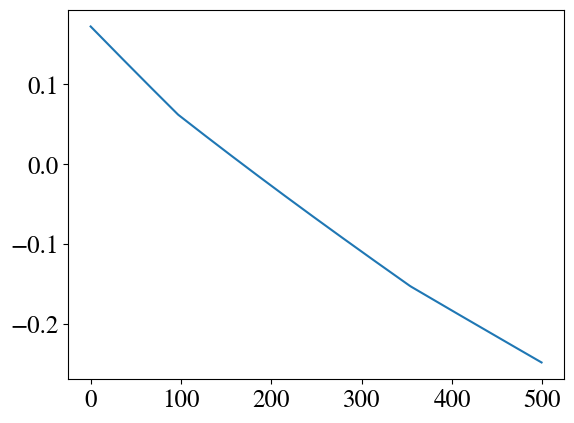

In [36]:
plt.plot(opt_values)

In [20]:
def generative_solve_cp(alpha, x, c_true, p, B):
    model = ro.Model()

    w = model.dvar(n)
    c = model.rvar(n)

    desired_coverage = 1 - alpha
    conformal_quantile = np.quantile(c_cal_scores, q = desired_coverage)
    c_hat = encoder.sample(1, x).detach().cpu().numpy()[0,0]
    uset = rso.norm(c - c_hat, 2) <= conformal_quantile
    
    model.minmax(-c @ w, uset)
    model.st(w <= 1)
    model.st(w >= 0)
    model.st(p @ w <= B)

    model.solve(grb)
    return 1, model.get()

# Visualize Region

In [21]:
def repeat_product(x, y):
    return np.transpose([np.tile(x, len(y)), 
                         np.repeat(y, len(x))])

x_sample = x_test[0:1]
c_sample = c_test[0:1]

c_hat = encoder.sample(k, x_sample).detach().cpu().numpy()[0]
c_mins = np.min(c_hat, axis=0) - 1
c_maxs = np.max(c_hat, axis=0) + 1

xx = np.arange(c_mins[0], c_maxs[0], 0.01)
yy = np.arange(c_mins[1], c_maxs[1], 0.01)
zz = repeat_product(xx, yy)
zz_tiled = np.transpose(np.tile(zz, (k, 1, 1)), (1, 0, 2))

grid_diff = zz_tiled - c_hat
grid_norms = np.linalg.norm(grid_diff, axis=-1)
grid_scores = np.min(grid_norms, axis=-1)
contained = grid_scores < conformal_quantile

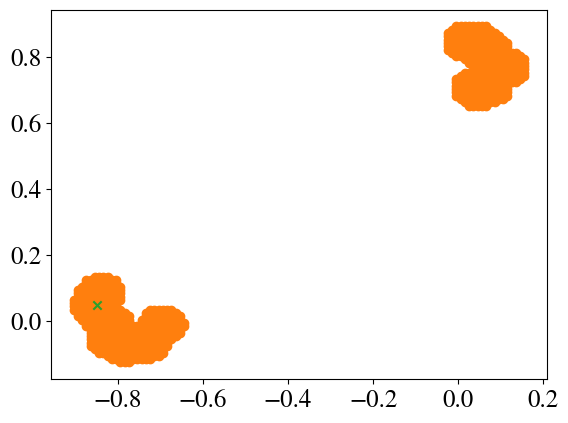

In [22]:
plt.scatter(c_hat[:,0], c_hat[:,1])
plt.scatter(zz[contained][:,0], zz[contained][:,1])
plt.scatter(c_sample[:,0], c_sample[:,1],marker="x")